In [18]:
!pip install --upgrade tensorflow-gpu

Requirement already up-to-date: tensorflow-gpu in /usr/local/lib/python3.6/dist-packages (2.0.0)


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
imdb_df = pd.read_csv("/content/drive/My Drive/SentimentAnalysisClassifier/Dataset/IMDB Dataset.csv")
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [22]:
imdb_df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [23]:
imdb_df.isna().sum()

review       0
sentiment    0
dtype: int64

In [30]:
imdb_df["target"] = imdb_df.sentiment.astype("category").cat.codes
imdb_df.head()


,review,sentiment,target
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


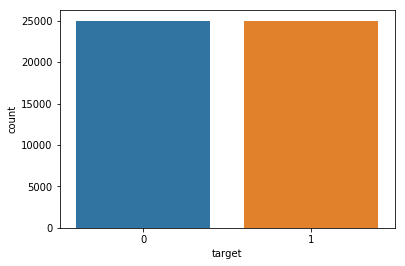

In [32]:
sns.countplot(imdb_df["target"])
plt.show()

In [34]:
imdb_df["review"] = imdb_df["review"].str.lower()
imdb_df["review"] = imdb_df["review"].str.replace("<>.,:/", " ")
imdb_df.head()

,review,sentiment,target
0,one of the other reviewers has mentioned that ...,positive,1
1,a wonderful little production. <br /><br />the...,positive,1
2,i thought this was a wonderful way to spend ti...,positive,1
3,basically there's a family where a little boy ...,negative,0
4,"petter mattei's ""love in the time of money"" is...",positive,1
